In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def convert_int_to_symbol(ls):
    """
    Convert, for example, 
    ['*', 'O', 'C', 'H', '3'] 
    to
    ['*', 'O', 'C', 'H', 'H', 'H']
    """
    try:
        parenthesis_left = ls.index('(')
        parenthesis_right = ls.index(')')
        len_par = parenthesis_right - parenthesis_left - 1
    except:
        pass
        
    converted_ls = []
    for i in range(len(ls)):
        try:
            multiple = int(ls[i])-1
            insert_elem = ls[i-1]
            if insert_elem != ')':
                for _ in range(multiple):
                    converted_ls.append(insert_elem)
            else:
                insert_elems = converted_ls[parenthesis_left:parenthesis_left+len_par]
                for j in range(multiple):
                    for k in range(len(insert_elems)):
                        converted_ls.append(insert_elems[k])
        except:
            if ls[i] != '(' and ls[i] != ')':
                converted_ls.append(ls[i])
            
    _ls = [x for x in converted_ls if x != '-']
    result_list = [x for x in _ls if x != '*']

    return result_list

def make_reaction(reactant, product):
    print(f'\n----- Entered -----')
    print(f' Reactant: {reactant}')
    print(f' Product: {product}')
    spl_product = convert_int_to_symbol(list(product))
    spl_reactant = convert_int_to_symbol(list(reactant))
    convert_tag = False
    if len(spl_product) < len(spl_reactant):
        for j in spl_product:
            if j in spl_reactant:
                del spl_reactant[spl_reactant.index(j)]
        # print(spl_reactant)
        if 'H' in spl_reactant and 'O' in spl_reactant:
            product = [product, 'H2O']
    elif len(spl_product) > len(spl_reactant):
        product = [product]  
    else:
        ractant = [reactant]
        product = [product] 
        convert_tag = True
        
    if '+' in list(product[0]):
        splited = product[0].split('+')
        del product[0]
        for element in splited:
            product.append(element)
    if '+' in list(reactant):
        splited = reactant.split('+')
        # print(f'### {reactant}')
        if '-2' in reactant:
            reactant = '*O-2'
        else:
            reactant = '*O'
            
    if type(product) != list:
        product = [product]       
    if '*' not in list(product[0]):
        product.append('*')
    if convert_tag:
        reactant = [reactant]
    else:
        reactant = [reactant, 'H']
    if '*' not in list(reactant[0]):
        reactant.append('*')

    print(f'----- Result  -----')
    print(f' Reaction: {reactant} -> {product}')
    
    return reactant, product

def calculate_chemical_potential(reactant, product, file_path, sheet_name=0):
    G_reactant = 0
    G_product = 0
    data = pd.read_excel(file_path, sheet_name)
    columns = data.columns
    target_column = 'G'
    column_index = list(columns).index(target_column)
    for symbol in reactant:
        row_index = data.index[data['Symbols'] == symbol][0] 
        G_reactant += data.iloc[row_index, column_index]
    for symbol in product:
        row_index = data.index[data['Symbols'] == symbol][0]
        G_product += data.iloc[row_index, column_index]
        
    return G_reactant, G_product

def plot_gibbs_energy_change(file_path='energies.xlsx',
                             sheet_name='Sheet1',
                             U=0.0,
                             non_e_p_transfer_step=0,
                             color=None,
                             figure_size=None,
                             reactions=None,
                             spanned_num=5):
    """
    1) file_path: str 
        path of xlsx file about Gibbs energy
    2) sheet_name: str
        sheet name of xlsx file
    2) U: float
        applied electrode potential
    3) non_e_p_transfer_step: int
        number of non (e- + H+) transfer steps
    4) color: list of str
        list of colors for plotting
    5) figure_size: list of int
        list of x and y coordinates
    6) reactions: dictionary of str 
        dictionary of reaction pathway
    7) spanned_num: int
        adjusting factor of bar's width of graph
    """
    if figure_size != None:
        x_axis = figure_size[0]
        y_axis = figure_size[1]
        plt.figure(figsize=(x_axis, y_axis))
    
    for k in range(len(reactions)):
        key = list(reactions.keys())[k]
        delta_G = [0]
        # path_symbols = list(reactions.keys())[1]
        print(f'\n\n============= {key} =============')
        path_symbols = reactions[key]
        # rxn_path = reactions[key]
        for i in range(len(path_symbols)-1):
            reactant, product = make_reaction(path_symbols[i], path_symbols[i+1])
            G_reactant, G_product = calculate_chemical_potential(reactant, 
                                                                 product, 
                                                                 file_path, 
                                                                 sheet_name)
            delta_G += [G_product - G_reactant + U] 
            print(f' => dG = {G_product - G_reactant - U:5.5f} eV')

        cumsum_E = np.cumsum(delta_G)
        spanned_enes = [e for e in cumsum_E for _ in range(spanned_num)]  
        sub_enes = [spanned_enes[i+1]-spanned_enes[i] for i in range(len(spanned_enes[:-1]))]
        
        if non_e_p_transfer_step == 0:
            xticks_labels = np.arange(0, len(reactions[key]), 1)
        else:
            xticks_labels = [0 for i in range(non_e_p_transfer_step)]
            add_range = np.arange(0, len(reactions[key])-non_e_p_transfer_step, 1)
            for i in range(len(add_range)):
                xticks_labels.append(add_range[i])

        xticks_positions = []
        for i in range(len(reactions[key])):
            xticks_positions.append(spanned_num*i+2)      
        maximum = max(sub_enes)
        print(f'\n ==> Negative limiting potential = {maximum:5.5f} eV')
        x = np.arange(0, len(spanned_enes), 1)
        plt.plot(x, spanned_enes, color = color[k], label=f'{key}', alpha = 0.8)
        plt.xticks(xticks_positions, xticks_labels, fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel(f'$\u0394G$ $(eV)$ at {U} V (vs. RHE)', fontsize=13)
        plt.xlabel(r'($H^+$ + $e^-$)' + ' transferred', fontsize=13)
        #plt.legend(loc='upper right', fontsize=12)
    print(f'\n\n')


In [3]:
file_path = '../../Data/geometry_relaxation_and_zpe/crr_intermediates_au-sto.xlsx'

## $C_1$ reaction



============= path1 =============

----- Entered -----
 Reactant: CO2
 Product: *COOH
----- Result  -----
 Reaction: ['CO2', 'H', '*'] -> ['*COOH']
 => dG = 0.83596 eV

----- Entered -----
 Reactant: *COOH
 Product: *CO
----- Result  -----
 Reaction: ['*COOH', 'H'] -> ['*CO', 'H2O']
 => dG = -0.34510 eV

----- Entered -----
 Reactant: *CO
 Product: *CHO
----- Result  -----
 Reaction: ['*CO', 'H'] -> ['*CHO']
 => dG = 0.18905 eV

----- Entered -----
 Reactant: *CHO
 Product: CH2*O
----- Result  -----
 Reaction: ['*CHO', 'H'] -> ['CH2*O']
 => dG = 0.08278 eV

----- Entered -----
 Reactant: CH2*O
 Product: CH3*O
----- Result  -----
 Reaction: ['CH2*O', 'H'] -> ['CH3*O']
 => dG = 0.73431 eV

----- Entered -----
 Reactant: CH3*O
 Product: *O+CH4
----- Result  -----
 Reaction: ['CH3*O', 'H'] -> ['*O', 'CH4']
 => dG = 0.94533 eV

----- Entered -----
 Reactant: *O+CH4
 Product: *OH
----- Result  -----
 Reaction: ['*O', 'H'] -> ['*OH']
 => dG = -2.04245 eV

----- Entered -----
 Reactant: *OH


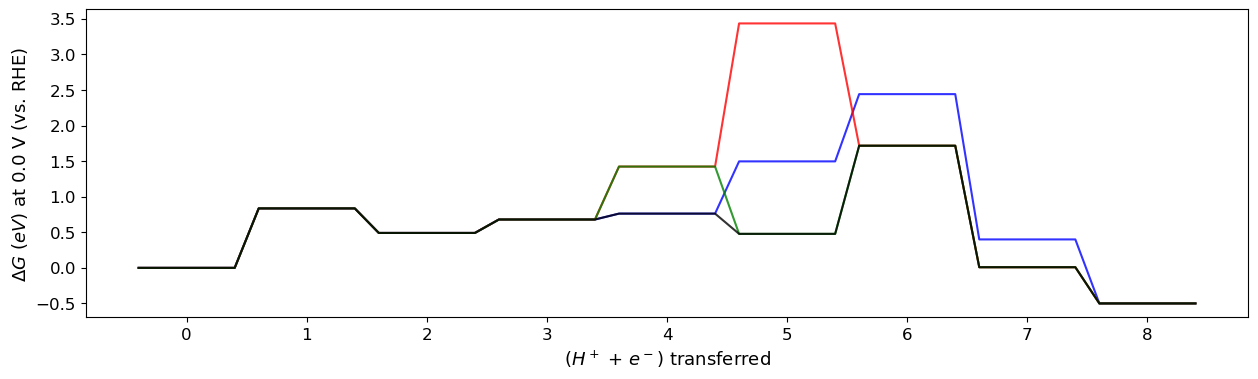

In [4]:
reactions = {'path1': ['CO2', '*COOH', '*CO', '*CHO', 'CH2*O', 'CH3*O', '*O+CH4', '*OH', 'H2O'],
             'path2': ['CO2', '*COOH', '*CO', '*CHO', '*CHOH', '*CH', '*CH2', '*CH3', 'CH4'],
             'path3': ['CO2', '*COOH', '*CO', '*CHO', '*CHOH', '*CH2OH', '*CH2', '*CH3', 'CH4'],
             'path4': ['CO2', '*COOH', '*CO', '*CHO', 'CH2*O', '*CH2OH', '*CH2', '*CH3', 'CH4']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C1',
                         U=0.0,
                         non_e_p_transfer_step=0,
                         color=['blue', 'red', 'green', 'black'],
                         figure_size=[15, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_2$ reaction: *$CO$ + *$CO$



============= CO + CO =============

----- Entered -----
 Reactant: *CO-*CO
 Product: *COH*CO
----- Result  -----
 Reaction: ['*CO-*CO', 'H'] -> ['*COH*CO']
 => dG = 2.06412 eV

----- Entered -----
 Reactant: *COH*CO
 Product: *CCO
----- Result  -----
 Reaction: ['*COH*CO', 'H'] -> ['*CCO', 'H2O']
 => dG = 0.72690 eV

----- Entered -----
 Reactant: *CCO
 Product: *CHCO
----- Result  -----
 Reaction: ['*CCO', 'H'] -> ['*CHCO']
 => dG = -1.67956 eV

----- Entered -----
 Reactant: *CHCO
 Product: *CHCH*O
----- Result  -----
 Reaction: ['*CHCO', 'H'] -> ['*CHCH*O']
 => dG = 0.66906 eV

----- Entered -----
 Reactant: *CHCH*O
 Product: CH2CH*O
----- Result  -----
 Reaction: ['*CHCH*O', 'H'] -> ['CH2CH*O']
 => dG = -0.20854 eV

----- Entered -----
 Reactant: CH2CH*O
 Product: CH3CH*O
----- Result  -----
 Reaction: ['CH2CH*O', 'H'] -> ['CH3CH*O']
 => dG = -1.10576 eV

----- Entered -----
 Reactant: CH3CH*O
 Product: CH3CH2*O
----- Result  -----
 Reaction: ['CH3CH*O', 'H'] -> ['CH3CH2*O']
 =>

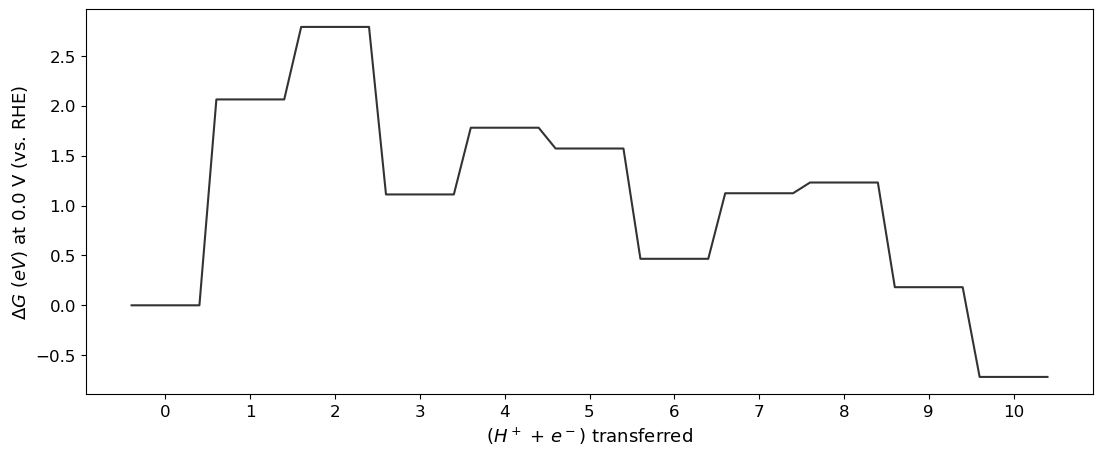

In [6]:
reactions = {'CO + CO': ['*CO-*CO', '*COH*CO', '*CCO', '*CHCO', '*CHCH*O', \
                       'CH2CH*O', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=0,
                         color=['black'],
                         figure_size=[13, 5],
                         reactions=reactions,
                         spanned_num=5)


## $C_2$ reaction: *$CH_2$ + *$CO$



============= CH2 + CO (1) =============

----- Entered -----
 Reactant: *CH2-*CO
 Product: CH2*C*O
----- Result  -----
 Reaction: ['*CH2-*CO'] -> ['CH2*C*O']
 => dG = 0.64993 eV

----- Entered -----
 Reactant: CH2*C*O
 Product: CH2CH*O
----- Result  -----
 Reaction: ['CH2*C*O', 'H'] -> ['CH2CH*O']
 => dG = 0.04446 eV

----- Entered -----
 Reactant: CH2CH*O
 Product: CH3CH*O
----- Result  -----
 Reaction: ['CH2CH*O', 'H'] -> ['CH3CH*O']
 => dG = -1.10576 eV

----- Entered -----
 Reactant: CH3CH*O
 Product: CH3CH2*O
----- Result  -----
 Reaction: ['CH3CH*O', 'H'] -> ['CH3CH2*O']
 => dG = 0.65726 eV

----- Entered -----
 Reactant: CH3CH2*O
 Product: *O+C2H6
----- Result  -----
 Reaction: ['CH3CH2*O', 'H'] -> ['*O', 'C2H6']
 => dG = 0.10755 eV

----- Entered -----
 Reactant: *O+C2H6
 Product: *OH
----- Result  -----
 Reaction: ['*O', 'H'] -> ['*OH']
 => dG = -1.04937 eV

----- Entered -----
 Reactant: *OH
 Product: H2O
----- Result  -----
 Reaction: ['*OH', 'H'] -> ['H2O', '*']
 => dG =

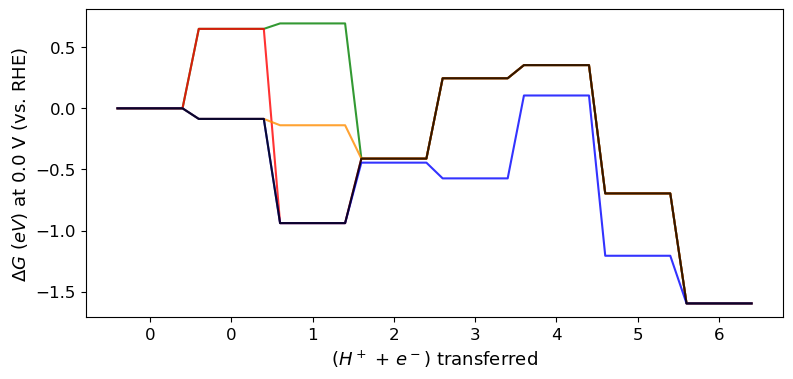

In [7]:
reactions = {'CH2 + CO (1)': ['*CH2-*CO', 'CH2*C*O', 'CH2CH*O', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             'CH2 + CO (2)': ['*CH2-*CO', 'CH2*C*O', '*COCH3', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             'CH2 + CO (3)': ['*CH2-*CO', '*CH2*CO', '*CH2CHO', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O'],
             'CH2 + CO (4)': ['*CH2-*CO', '*CH2*CO', '*COCH3', '*COHCH3', '*CHOHCH3', '*CHCH3', '*CH2CH3', 'C2H6'],
             'CH2 + CO (5)': ['*CH2-*CO', '*CH2*CO', '*COCH3', 'CH3CH*O', 'CH3CH2*O', '*O+C2H6', '*OH', 'H2O']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['green', 'red', 'darkorange', 'blue', 'black'],
                         figure_size=[9, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_2$ reaction: *$CH_2$ + *$CH_2$



============= CH2 + CH2 =============

----- Entered -----
 Reactant: *CH2-*CH2
 Product: *C2H4
----- Result  -----
 Reaction: ['*CH2-*CH2'] -> ['*C2H4']
 => dG = -1.83566 eV

----- Entered -----
 Reactant: *C2H4
 Product: *CH2CH3
----- Result  -----
 Reaction: ['*C2H4', 'H'] -> ['*CH2CH3']
 => dG = -0.10113 eV

----- Entered -----
 Reactant: *CH2CH3
 Product: C2H6
----- Result  -----
 Reaction: ['*CH2CH3', 'H'] -> ['C2H6', '*']
 => dG = -0.38981 eV

 ==> Negative limiting potential = 0.00000 eV





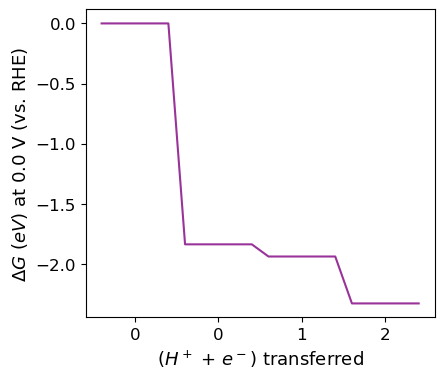

In [9]:
reactions = {'CH2 + CH2': ['*CH2-*CH2', '*C2H4', '*CH2CH3', 'C2H6']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C2',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4.5, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_3$ reaction: *$CO$ insertion



============= CO insertion =============

----- Entered -----
 Reactant: *CH2CH3-*CO
 Product: *COCH2CH3
----- Result  -----
 Reaction: ['*CH2CH3-*CO'] -> ['*COCH2CH3']
 => dG = -0.21499 eV

----- Entered -----
 Reactant: *COCH2CH3
 Product: *COHCH2CH3
----- Result  -----
 Reaction: ['*COCH2CH3', 'H'] -> ['*COHCH2CH3']
 => dG = 0.30639 eV

----- Entered -----
 Reactant: *COHCH2CH3
 Product: *CHOHCH2CH3
----- Result  -----
 Reaction: ['*COHCH2CH3', 'H'] -> ['*CHOHCH2CH3']
 => dG = -0.04213 eV

----- Entered -----
 Reactant: *CHOHCH2CH3
 Product: *CHCH2CH3
----- Result  -----
 Reaction: ['*CHOHCH2CH3', 'H'] -> ['*CHCH2CH3', 'H2O']
 => dG = 0.43350 eV

----- Entered -----
 Reactant: *CHCH2CH3
 Product: *CH2CH2CH3
----- Result  -----
 Reaction: ['*CHCH2CH3', 'H'] -> ['*CH2CH2CH3']
 => dG = -0.99082 eV

----- Entered -----
 Reactant: *CH2CH2CH3
 Product: C3H8
----- Result  -----
 Reaction: ['*CH2CH2CH3', 'H'] -> ['C3H8', '*']
 => dG = -0.49047 eV

 ==> Negative limiting potential = 0.4335

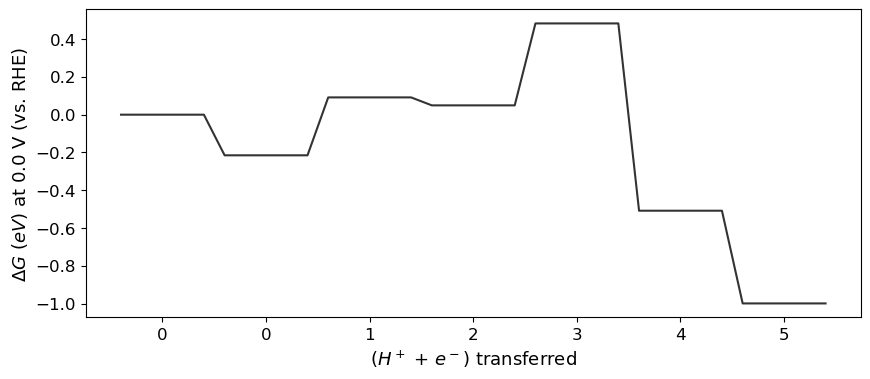

In [10]:
reactions = {'CO insertion': ['*CH2CH3-*CO', '*COCH2CH3', '*COHCH2CH3', '*CHOHCH2CH3', '*CHCH2CH3', '*CH2CH2CH3', 'C3H8']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C3',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['black', 'red', 'blue'],
                         figure_size=[10, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_3$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2CH3-*CH2
 Product: *CH2CH2CH3
----- Result  -----
 Reaction: ['*CH2CH3-*CH2'] -> ['*CH2CH2CH3']
 => dG = -1.35708 eV

----- Entered -----
 Reactant: *CH2CH2CH3
 Product: C3H8
----- Result  -----
 Reaction: ['*CH2CH2CH3', 'H'] -> ['C3H8', '*']
 => dG = -0.49047 eV

 ==> Negative limiting potential = 0.00000 eV





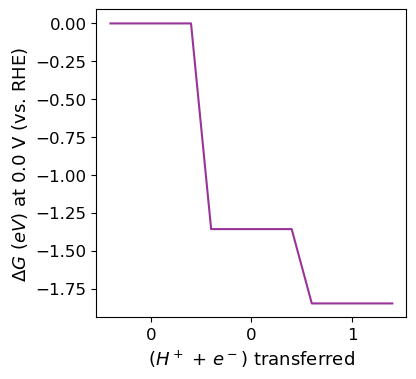

In [11]:
reactions = {'CH2 insertion': ['*CH2CH3-*CH2', '*CH2CH2CH3', 'C3H8']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C3',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_4$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2CH2CH3-*CH2
 Product: *CH2(CH2)2CH3
----- Result  -----
 Reaction: ['*CH2CH2CH3-*CH2'] -> ['*CH2(CH2)2CH3']
 => dG = -1.38224 eV

----- Entered -----
 Reactant: *CH2(CH2)2CH3
 Product: C4H10
----- Result  -----
 Reaction: ['*CH2(CH2)2CH3', 'H'] -> ['C4H10', '*']
 => dG = -0.44805 eV

 ==> Negative limiting potential = 0.00000 eV





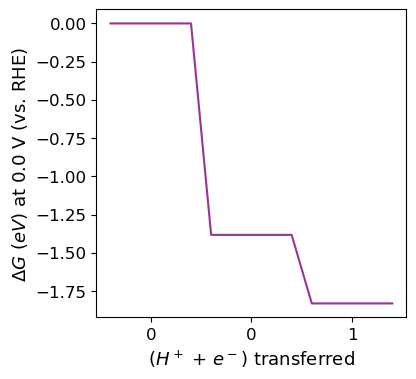

In [12]:
reactions = {'CH2 insertion': ['*CH2CH2CH3-*CH2', '*CH2(CH2)2CH3', 'C4H10']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_5$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)2CH3-*CH2
 Product: *CH2(CH2)3CH3
----- Result  -----
 Reaction: ['*CH2(CH2)2CH3-*CH2'] -> ['*CH2(CH2)3CH3']
 => dG = -1.25030 eV

----- Entered -----
 Reactant: *CH2(CH2)3CH3
 Product: C5H12
----- Result  -----
 Reaction: ['*CH2(CH2)3CH3', 'H'] -> ['C5H12', '*']
 => dG = -0.56941 eV

 ==> Negative limiting potential = 0.00000 eV





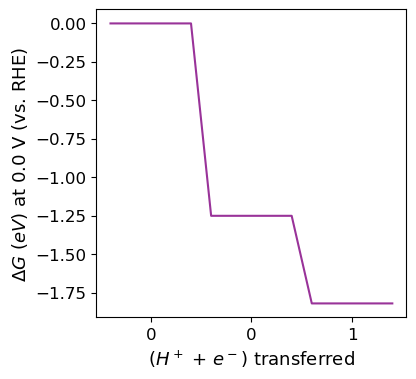

In [13]:
reactions = {'CH2 insertion': ['*CH2(CH2)2CH3-*CH2', '*CH2(CH2)3CH3', 'C5H12']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)


## $C_6$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)3CH3-*CH2
 Product: *CH2(CH2)4CH3
----- Result  -----
 Reaction: ['*CH2(CH2)3CH3-*CH2'] -> ['*CH2(CH2)4CH3']
 => dG = -1.28481 eV

----- Entered -----
 Reactant: *CH2(CH2)4CH3
 Product: C6H14
----- Result  -----
 Reaction: ['*CH2(CH2)4CH3', 'H'] -> ['C6H14', '*']
 => dG = -0.60976 eV

 ==> Negative limiting potential = 0.00000 eV





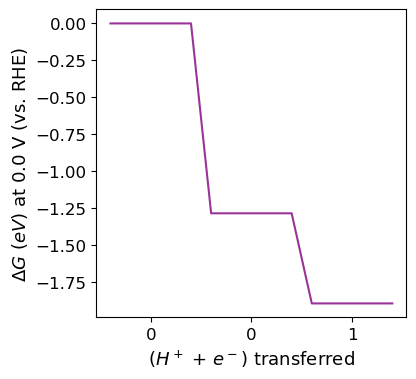

In [14]:
reactions = {'CH2 insertion': ['*CH2(CH2)3CH3-*CH2', '*CH2(CH2)4CH3', 'C6H14']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)
    

## $C_7$ reaction: *$CH_2$ insertion



============= CH2 insertion =============

----- Entered -----
 Reactant: *CH2(CH2)4CH3-*CH2
 Product: *CH2(CH2)5CH3
----- Result  -----
 Reaction: ['*CH2(CH2)4CH3-*CH2'] -> ['*CH2(CH2)5CH3']
 => dG = -1.32345 eV

----- Entered -----
 Reactant: *CH2(CH2)5CH3
 Product: C7H16
----- Result  -----
 Reaction: ['*CH2(CH2)5CH3', 'H'] -> ['C7H16', '*']
 => dG = -0.58974 eV

 ==> Negative limiting potential = 0.00000 eV





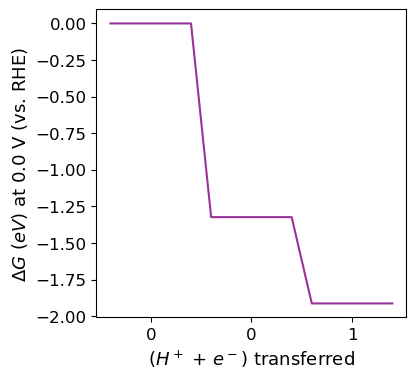

In [15]:
reactions = {'CH2 insertion': ['*CH2(CH2)4CH3-*CH2', '*CH2(CH2)5CH3', 'C7H16']}

plot_gibbs_energy_change(file_path=file_path,
                         sheet_name='C4-C7',
                         U=0.0,
                         non_e_p_transfer_step=1,
                         color=['purple'],
                         figure_size=[4, 4],
                         reactions=reactions,
                         spanned_num=5)
